In [1]:
#importing libraries
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
import pickle
import warnings
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
warnings.filterwarnings("ignore")

In [2]:
#importing data
X_train1 = pd.read_csv("X_train.csv")
X_test1 = pd.read_csv("X_test.csv")
y_train1 = pd.read_csv("y_train.csv")
y_test1 = pd.read_csv("y_test.csv")

#### Exploring the data

In [3]:
X_train1.head(2)

,business_id,city,state,business_stars,business_review_count,is_open,categories,BusinessAcceptsCreditCards,restaurant_price_level,BikeParking,...,valet_parking,review_id,review_stars,review_useful,review_funny,review_cool,user_id,user_review_count,user_average_stars,checkin_review_count
0,8HP8_kW6xroh5jCkh4uigA,Wynnewood,PA,4.0,492,1,"Dim Sum, Restaurants, Chinese, Asian Fusion",1,2,True,...,0,MViUwxG0hBfWOaNm56AD4w,5,0,0,0,XslAfrZEnqlXwoHW2NRr1g,14.0,3.73,1052.0
1,kLas0AKQ5D0HoIqPYsqrIQ,Pennsauken Township,NJ,2.0,16,0,"Cheesesteaks, Sandwiches, Pizza, Restaurants",1,0,True,...,0,CVC0J_aqeLt5yA8B4W-iaQ,5,0,0,0,J9ijsb9e0wGAOSetBUrWFw,8.0,4.63,1.0


In [4]:
X_train1.columns

Index(['business_id', 'city', 'state', 'business_stars',
       'business_review_count', 'is_open', 'categories',
       'BusinessAcceptsCreditCards', 'restaurant_price_level', 'BikeParking',
       'parking_garage', 'parking_street', 'lot_parking', 'valet_parking',
       'review_id', 'review_stars', 'review_useful', 'review_funny',
       'review_cool', 'user_id', 'user_review_count', 'user_average_stars',
       'checkin_review_count'],
      dtype='object')

In [5]:
X_train1.shape

(4462882, 23)

In [6]:
y_train1.head(2)

,validated_parking
0,0
1,0


#### Dataset size is huge, lets reduce that by sampling

In [7]:
#adding them together for training set and using group by for balanced classes
df = pd.concat([X_train1, y_train1], axis=1)
min_samples = 30000
df_downsampled1 = df.groupby('validated_parking').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)
#shuffle the dataset
df_downsampled = df_downsampled1.sample(frac=1).reset_index(drop=True)
X_train = df_downsampled.drop(columns='validated_parking')
y_train = df_downsampled['validated_parking']



#for testing set
df_test = pd.concat([X_test1, y_test1], axis=1)
min_samples=12000
df_test_downsampled2 = df_test.sample(min_samples,random_state=42)
#shuffle the dataset
df_test_downsampled = df_test_downsampled2.sample(frac=1).reset_index(drop=True)
X_test = df_test_downsampled.drop(columns='validated_parking')
y_test = df_test_downsampled['validated_parking']





In [8]:
X_train.shape,X_test.shape

((60000, 23), (12000, 23))

### Lets check unique values in all categorical columns

In [9]:
for col in X_train.select_dtypes(include='object'):
    print(f"Value counts for column {col}:")
    print(df[col].nunique())

Value counts for column business_id:
76623
Value counts for column city:
1023
Value counts for column state:
16
Value counts for column categories:
50375
Value counts for column review_id:
4462882
Value counts for column user_id:
1433711


In [10]:
#lets drop business_id, userid and review_id from train and test sets
X_train = X_train.drop(columns=['business_id',"user_id",'review_id'], axis=1)
X_test = X_test.drop(columns=['business_id',"user_id",'review_id'], axis=1)

### Lets frequency encode city and state columns

In [11]:
#get value counts of all unique values in city as a dictionary
city_frequency = X_train['city'].value_counts()

In [12]:
#map the values inside city to new columnm for train and test sets
X_train['city_freq'] = X_train['city'].map(city_frequency)
X_test['city_freq'] = X_test['city'].map(city_frequency)
X_train['city_freq'][0:5]

0    12424
1     2907
2      235
3     4518
4     3113
Name: city_freq, dtype: int64

In [13]:
#get value counts of all unique values in state as a dictionary
state_frequency = X_train['state'].value_counts()

In [14]:
#map the values inside state to new column
X_train['state_freq'] = X_train['state'].map(state_frequency)
X_test['state_freq'] = X_test['state'].map(state_frequency)
X_train['state_freq'][0:5]

0    15651
1     3033
2     3146
3     5296
4     8306
Name: state_freq, dtype: int64

### As we have encoded the data, we can drop the original columns from or dataframe

In [15]:
X_train = X_train.drop(columns=['city','state'],axis = 1)
X_test = X_test.drop(columns=['city','state'],axis = 1)

#### Lets look at the categorical columns again

In [16]:
for col in X_train.select_dtypes(include='object'):
    print(f"Value counts for column {col}:")
    print(df[col].nunique())

Value counts for column categories:
50375


In [17]:
#check value type of data in categories 
for x in X_train.loc[:5,'categories']:
    print(type(x))


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [18]:
X_train['categories'][0:5]

0                    Restaurants, Steakhouses, Seafood
1    Fruits & Veggies, Mexican, Restaurants, Specia...
2                      Restaurants, Mongolian, Chinese
3    Cocktail Bars, Bars, Restaurants, Seafood, Sou...
4    Japanese, Cocktail Bars, Bars, Nightlife, Dine...
Name: categories, dtype: object

#### As all values inside categories are string values, lets start with splitting the words. 

In [19]:
#lets split string values to list in each row in categories using a comma 
X_train['categories_list'] = X_train['categories'].apply(lambda x: x.split(', '))
X_train['categories_list'][0:5]

0                  [Restaurants, Steakhouses, Seafood]
1    [Fruits & Veggies, Mexican, Restaurants, Speci...
2                    [Restaurants, Mongolian, Chinese]
3    [Cocktail Bars, Bars, Restaurants, Seafood, So...
4    [Japanese, Cocktail Bars, Bars, Nightlife, Din...
Name: categories_list, dtype: object

### Now, lets flatten our column put each unique catefory in a list

In [20]:

all_categories = []

#iterate over each list in 'categories_list'
for sublist in X_train['categories_list']:
    #iterate over each category in the sublist
    for item in sublist:
        #append each category to the flat list
        all_categories.append(item)
print("Numer of words in list",len(all_categories))

Numer of words in list 384253


#### We have 384253 items in the list, lets take the top 10 values that repeat the most inside the list using counter

In [21]:
category_counts = Counter(all_categories)

In [22]:
#get the 10 most common categories
most_common_categories = category_counts.most_common(10)

#initialize an empty list to store the top common words
top_common_words = []

# Loop through the most common categories
for word, count in most_common_categories:
    # Append only the word top_common_words list
    top_common_words.append(word)

print(top_common_words)

['Restaurants', 'Nightlife', 'Bars', 'Food', 'American (New)', 'Seafood', 'American (Traditional)', 'Breakfast & Brunch', 'Sandwiches', 'Event Planning & Services']


### Now, we will make individual columns for these categories and treat them as one hot encoding

In [23]:
#initialize columns with 0 values
for category in top_common_words:
    X_train[category] = 0
    X_test[category] =0

#iterate through the rows and set 1 where a category is found
for index, row in X_train.iterrows():
    for category in top_common_words:
        if category in row['categories']:
            X_train.at[index, category] = 1


for index, row in X_test.iterrows():
    for category in top_common_words:
        if category in row['categories']:
            X_test.at[index, category] = 1

In [24]:
X_train.columns

Index(['business_stars', 'business_review_count', 'is_open', 'categories',
       'BusinessAcceptsCreditCards', 'restaurant_price_level', 'BikeParking',
       'parking_garage', 'parking_street', 'lot_parking', 'valet_parking',
       'review_stars', 'review_useful', 'review_funny', 'review_cool',
       'user_review_count', 'user_average_stars', 'checkin_review_count',
       'city_freq', 'state_freq', 'categories_list', 'Restaurants',
       'Nightlife', 'Bars', 'Food', 'American (New)', 'Seafood',
       'American (Traditional)', 'Breakfast & Brunch', 'Sandwiches',
       'Event Planning & Services'],
      dtype='object')

### As our categories column has been handled, we can drop the extra columns

In [25]:
X_train = X_train.drop(columns=['categories','categories_list'],axis=1)
X_test = X_test.drop(columns=['categories'],axis=1)

In [26]:
X_train.describe(include='all')

,business_stars,business_review_count,is_open,BusinessAcceptsCreditCards,restaurant_price_level,BikeParking,parking_garage,parking_street,lot_parking,valet_parking,...,Restaurants,Nightlife,Bars,Food,American (New),Seafood,American (Traditional),Breakfast & Brunch,Sandwiches,Event Planning & Services
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,48839,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.844550,770.805867,0.828433,0.964483,1.938117,NaN,0.303783,0.574350,0.446717,0.168517,...,0.852200,0.321800,0.366533,0.331167,0.229367,0.205100,0.196367,0.177333,0.097817,0.094350
std,0.585804,1218.329686,0.377007,0.185083,0.662189,NaN,0.459894,0.494445,0.497157,0.374328,...,0.354905,0.467171,0.481862,0.470637,0.420429,0.403778,0.397252,0.381954,0.297069,0.292317
min,1.000000,5.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,110.000000,1.000000,1.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,296.500000,1.000000,1.000000,2.000000,NaN,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,783.000000,1.000000,1.000000,2.000000,NaN,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
X_train.dtypes

business_stars                float64
business_review_count           int64
is_open                         int64
BusinessAcceptsCreditCards      int64
restaurant_price_level          int64
BikeParking                      bool
parking_garage                  int64
parking_street                  int64
lot_parking                     int64
valet_parking                   int64
review_stars                    int64
review_useful                   int64
review_funny                    int64
review_cool                     int64
user_review_count             float64
user_average_stars            float64
checkin_review_count          float64
city_freq                       int64
state_freq                      int64
Restaurants                     int64
Nightlife                       int64
Bars                            int64
Food                            int64
American (New)                  int64
Seafood                         int64
American (Traditional)          int64
Breakfast & 

In [28]:
X_train['BikeParking'].value_counts()

BikeParking
True     48839
False    11161
Name: count, dtype: int64

In [29]:
#lets change bool to int type
X_train['BikeParking'] =  X_train['BikeParking'].astype(int)
X_test['BikeParking'] =  X_test['BikeParking'].astype(int)

In [30]:
X_train['BikeParking'][0:3]

0    1
1    1
2    1
Name: BikeParking, dtype: int32

### Lets build a pipeline to standardscale our data

In [31]:
#extract numerical columns manually
numerical_columns = ['business_stars', 'business_review_count','review_stars','review_useful', 'review_funny', 'review_cool',
       'user_review_count', 'user_average_stars', 'checkin_review_count',
       'city_freq', 'state_freq']


#create preprocesser object and ignore rest of the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  
    ],
    remainder='passthrough'
)

In [32]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [33]:
X_test_processed

array([[ 0.26536412, -0.38397633,  0.11134911, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.26536412, -0.56865695,  0.84142745, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.11889942, -0.56455293,  0.11134911, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11889942, -0.29861285,  0.84142745, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.26536412, -0.06714648,  0.84142745, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.11889942, -0.48985989,  0.84142745, ...,  0.        ,
         0.        ,  0.        ]])

In [34]:
y_test.value_counts()

validated_parking
0    11663
1      337
Name: count, dtype: int64

### Heavily imbalanced test data, might affect scores in predictions

### Lets start modelling

In [35]:
model = XGBClassifier(
    n_estimators=100,         #number of trees 
    learning_rate=0.1,        #step size shrinkage 
    max_depth=6,              #maximum depth of tree
    subsample=0.8,            #fraction of training data to use 
    colsample_bytree=0.8,     #fraction of features to use per tree 
    objective='binary:logistic',  
    random_state=42           
)        



In [36]:
model.fit(X_train_processed,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Lets check metrics on train set and test set

In [37]:
y_pred_train = model.predict(X_train_processed)
y_pred_test = model.predict(X_test_processed)

#generate scores for train
recall_train=recall_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='binary')  
f1_train = f1_score(y_train, y_pred_train, average='binary')  

#generate scores for test
recall_test=recall_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='binary')  
f1_test = f1_score(y_test, y_pred_test, average='binary')  

#output the results
print(f'Accuracy for train: {accuracy_train:.4f}')
print(f'Accuracy for test: {accuracy_test:.4f}')
print(f'Precision for train: {precision_train:.4f}')
print(f'Precision for test: {precision_test:.4f}')
print(f'F1 Score for train: {f1_train:.4f}')
print(f'F1 Score for test: {f1_test:.4f}')
print(f'Recall score for train: {recall_train:.4f}')
print(f'Recall score for test: {recall_test:.4f}')


Accuracy for train: 0.9482
Accuracy for test: 0.9587
Precision for train: 0.9603
Precision for test: 0.3992
F1 Score for train: 0.9475
F1 Score for test: 0.5595
Recall score for train: 0.9351
Recall score for test: 0.9347


### Classification report

In [38]:
print("\nClassification Report for Training set:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report for testing set:\n", classification_report(y_test, y_pred_test))


Classification Report for Training set:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     30000
           1       0.96      0.94      0.95     30000

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000


Classification Report for testing set:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     11663
           1       0.40      0.93      0.56       337

    accuracy                           0.96     12000
   macro avg       0.70      0.95      0.77     12000
weighted avg       0.98      0.96      0.97     12000



### Confusion Matrix for train set

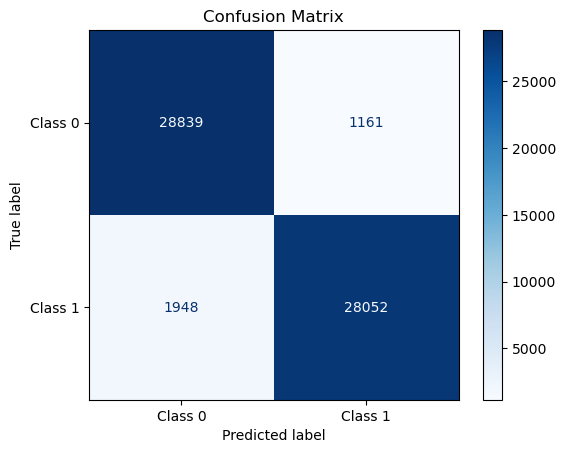

In [39]:

y_pred_train = model.predict(X_train_processed)
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix for test set

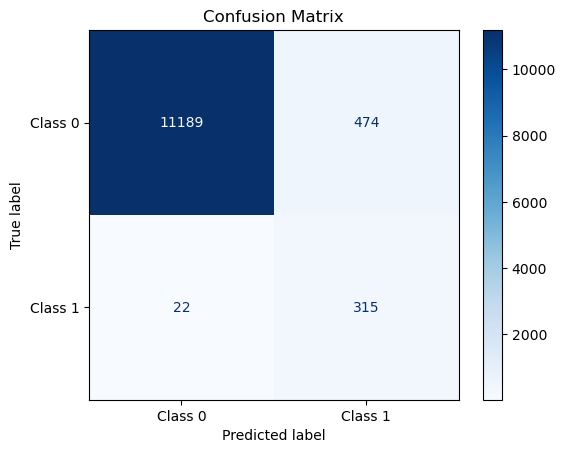

In [41]:

y_pred_test = model.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

### Lot of False positives, but that is majorly because of the imbalanced dataset in test. Our training set was balanced on target column. Our model may be predicting that there is validated parking, when there might not be. 

### Lets check AUC for train set

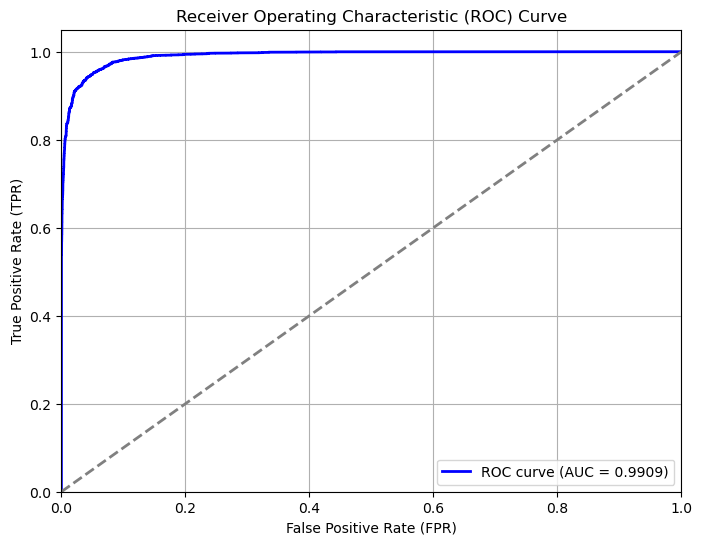

In [42]:
y_prob_train = model.predict_proba(X_train_processed)[:, 1]

#compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)

#compute the AUC score
roc_auc = auc(fpr, tpr)

#plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### AUC for test set

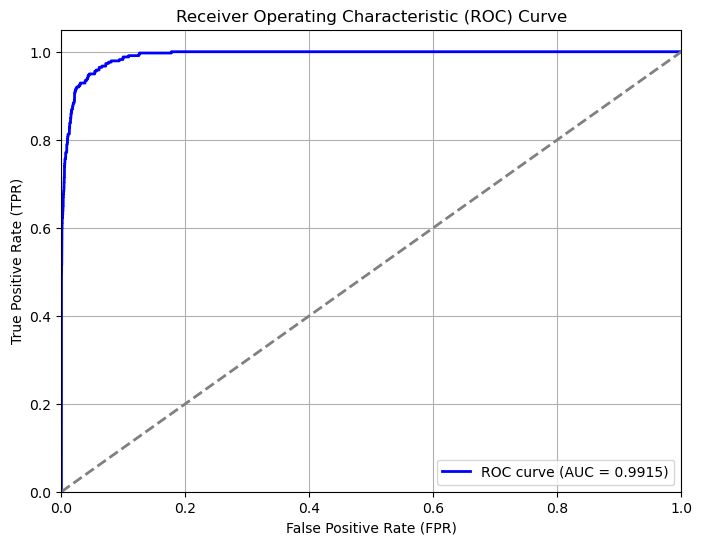

In [43]:
y_prob_test = model.predict_proba(X_test_processed)[:, 1]

#compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

#compute the AUC score
roc_auc = auc(fpr, tpr)

#plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Even though Test AUC performed better than Train AUC, Precision scores for class 1 were low because of the data imabalance in our test class, and precision also effects F1 score. Recall score is good. 

## Lets increase the number of trees to make the model more complex, but reduce the learning rate by half and reduce max_depth to limit overfitting 

In [44]:
model2 = XGBClassifier(
    n_estimators=750,         #number of trees 
    learning_rate=0.05,        #step size shrinkage 
    max_depth=5,              #maximum depth of tree
    subsample=0.8,            #fraction of training data to use 
    colsample_bytree=0.8,     #fraction of features to use per tree 
    objective='binary:logistic',  
    reg_alpha=0.1,              
    reg_lambda=2,
    random_state=42           
)        


In [45]:
model2.fit(X_train_processed,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [46]:
y_pred_train = model2.predict(X_train_processed)
y_pred_test = model2.predict(X_test_processed)

#generate scores for train
recall_train=recall_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='binary')  
f1_train = f1_score(y_train, y_pred_train, average='binary')  

#generate scores for test
recall_test=recall_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='binary')  
f1_test = f1_score(y_test, y_pred_test, average='binary')  

#output the results
print(f'Accuracy for train: {accuracy_train:.4f}')
print(f'Accuracy for test: {accuracy_test:.4f}')
print(f'Precision for train: {precision_train:.4f}')
print(f'Precision for test: {precision_test:.4f}')
print(f'F1 Score for train: {f1_train:.4f}')
print(f'F1 Score for test: {f1_test:.4f}')
print(f'Recall score for train: {recall_train:.4f}')
print(f'Recall score for test: {recall_test:.4f}')

Accuracy for train: 0.9794
Accuracy for test: 0.9718
Precision for train: 0.9790
Precision for test: 0.4985
F1 Score for train: 0.9794
F1 Score for test: 0.6593
Recall score for train: 0.9798
Recall score for test: 0.9733


In [47]:
print("\nClassification Report for Training set:\n", classification_report(y_train, y_pred_train))
print("\nClassification Report for testing set:\n", classification_report(y_test, y_pred_test))


Classification Report for Training set:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     30000
           1       0.98      0.98      0.98     30000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000


Classification Report for testing set:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     11663
           1       0.50      0.97      0.66       337

    accuracy                           0.97     12000
   macro avg       0.75      0.97      0.82     12000
weighted avg       0.99      0.97      0.98     12000



### Confusion Matrix for train set

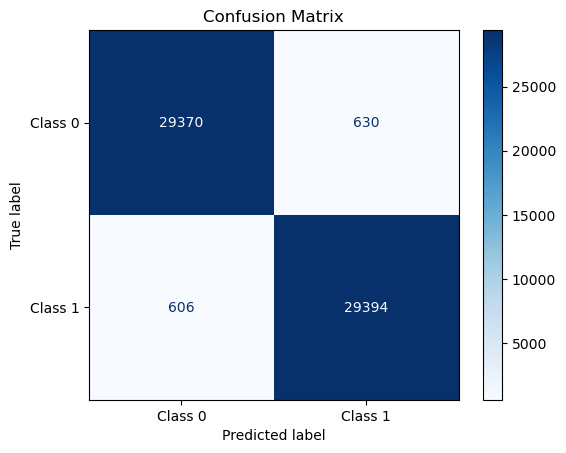

In [48]:

y_pred_train = model2.predict(X_train_processed)
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix for test set

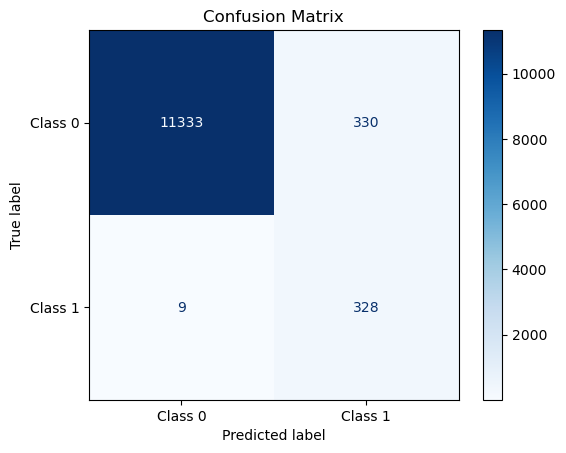

In [49]:

y_pred_test = model2.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

### AUC for train set

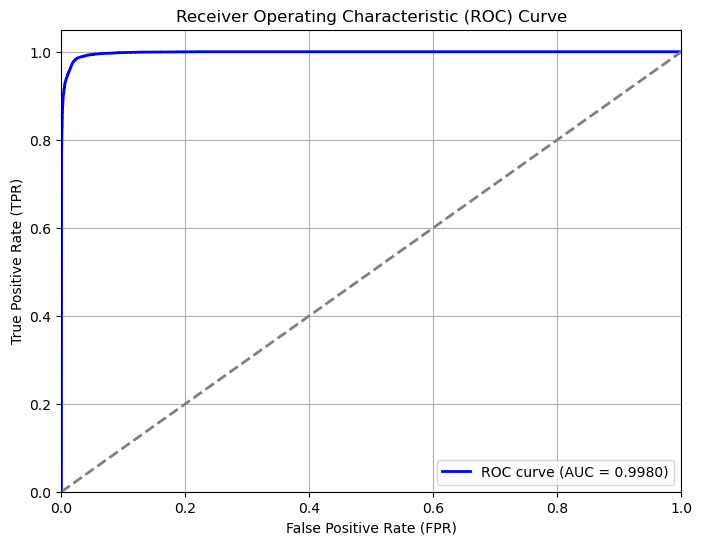

In [50]:
y_prob_train = model2.predict_proba(X_train_processed)[:, 1]

#compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)

#compute the AUC score
roc_auc = auc(fpr, tpr)

#plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### AUC for test set

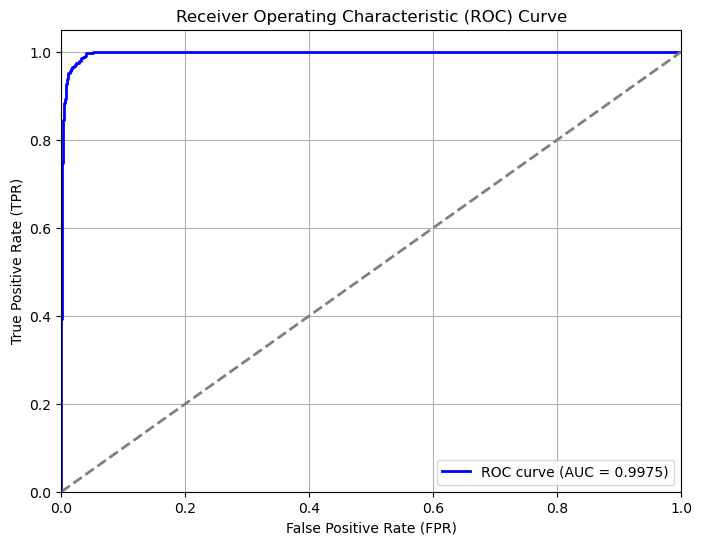

In [51]:
y_prob_test = model2.predict_proba(X_test_processed)[:, 1]

#compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

#compute the AUC score
roc_auc = auc(fpr, tpr)

#plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [52]:
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model2, file)

print("Model saved to 'xgboost_model.pkl'")

Model saved to 'xgboost_model.pkl'


### As the model is performing very well with overfitting visible in decimals, lets start with model interpretability

#### Local interpretability using SHAP

In [53]:
import shap

In [54]:
#create explainer on xgboost model
original_feature_names = X_test.columns.to_list()
explainer = shap.Explainer(model2,feature_names=original_feature_names)

instance = X_test_processed[0:1]

#use explainer on 1 instance
shap_values = explainer(instance)

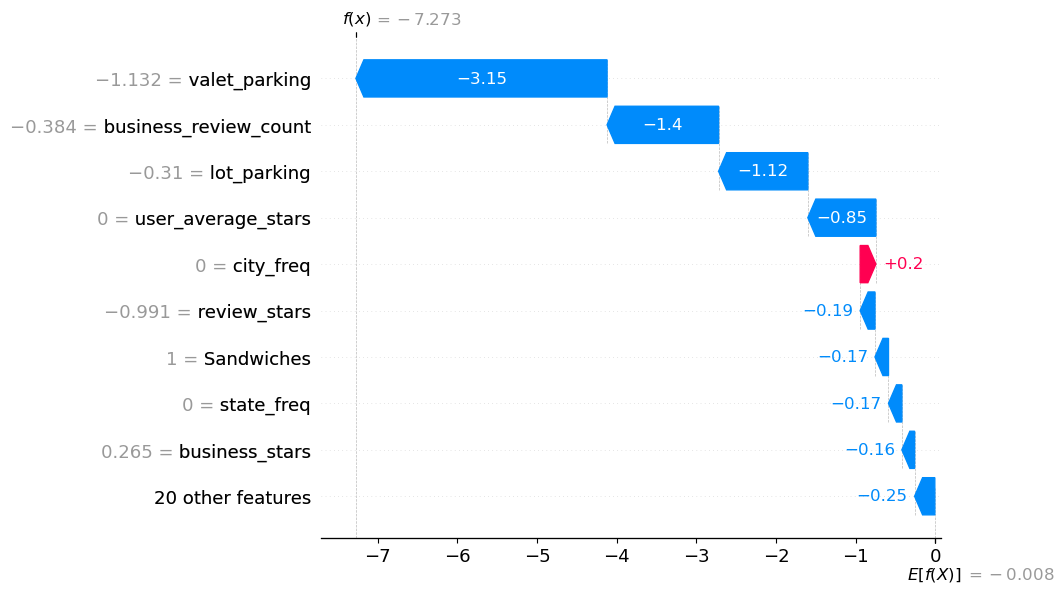

In [55]:
#waterfall plot
shap.plots.waterfall(shap_values[0])

In [56]:
y_test[0]

0

### The class for this label is 0
#### The features with the largest impact are valet parking, business review count, lot parking and user average stars that decreases that push the prediction toward class 0
### Lets take another instance where the label is 1

In [72]:
y_test[79]

1

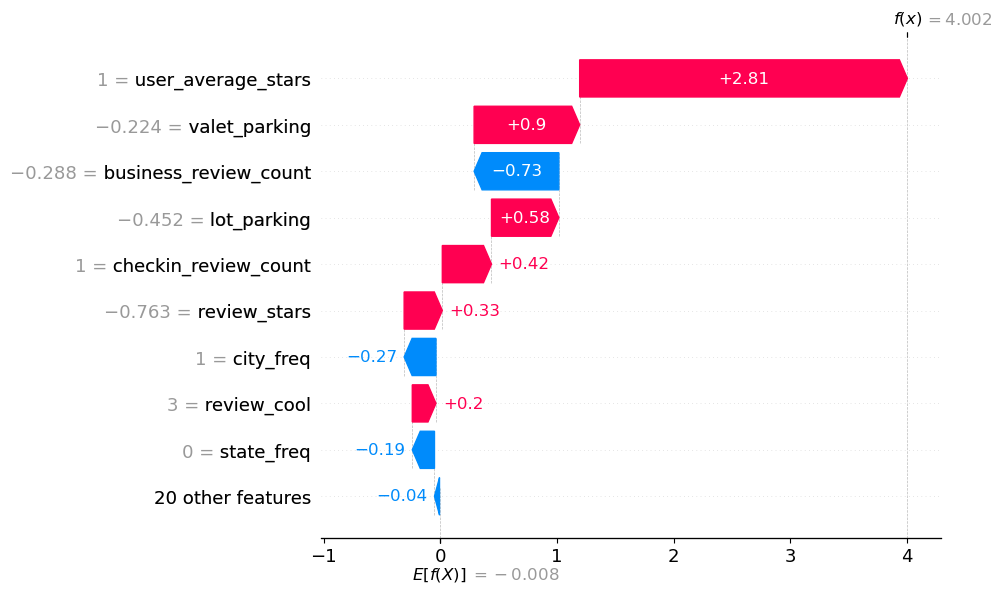

In [73]:

instance = X_test_processed[79].reshape(1, -1)

#use explainer on 1 instance
shap_values = explainer(instance)

#waterfall plot
shap.plots.waterfall(shap_values[0])

### The class for this data is 1

#### User Average Stars is the strongest positive influence on the prediction towards class 1, along with valet parking and lot parking,  where as business review count is the biggest negative influence. The higher the average of user stars, the more likely the business to have validated parking


## Lets work on global interpretability


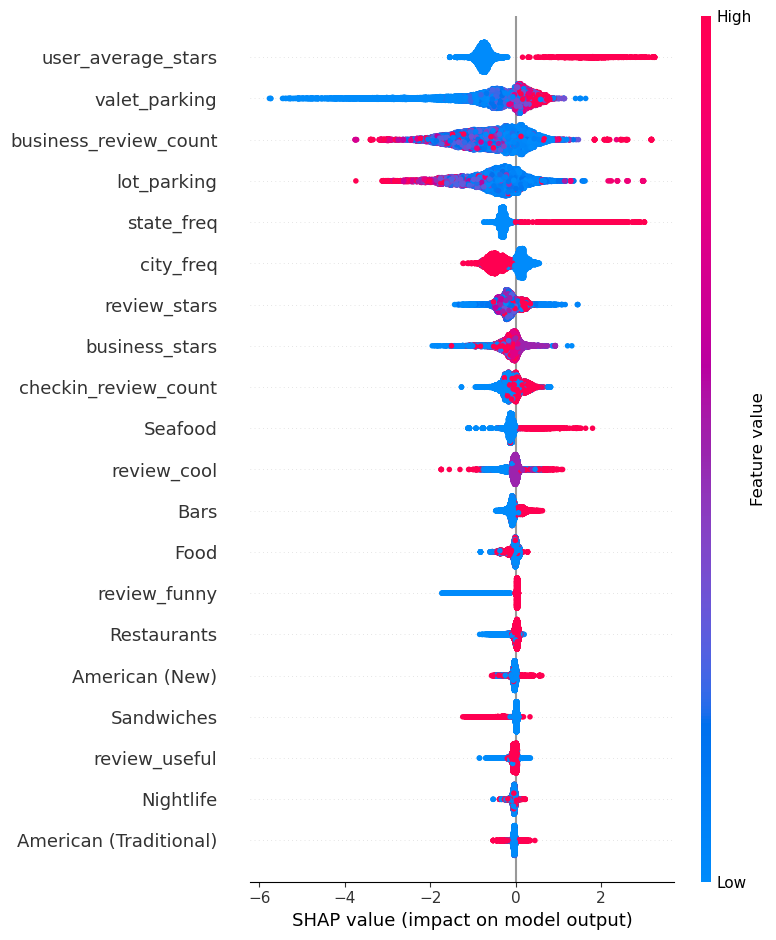

In [74]:
#use whole dataset
shap_values = explainer(X_test_processed)

#summary plot for global interpretability
shap.summary_plot(shap_values, X_test_processed, feature_names=original_feature_names)

### The top features driving the  predictions are user average Stars, business review count, and valet parking and lot parking
#### Red values tend to push predictions towards class 1, user average stars and state freq have extreme red values
#### Blue values tend to push prediciton towards class 0, valet parking has extreme ends affecting class 0 the most, with state freq, business review count, lot parking and user average stars
